# Статистика, DS-поток
## Задание SP.7

**Правила:**

* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds23_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. Дождитесь подтверждения от бота, что он принял файл. Если подтверждения нет, то что-то не так. **Работы, присланные иным способом, не принимаются.**
* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания получат штраф.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* В каждой задаче не забывайте делать **пояснения и выводы**.
* **Код из рассказанных на занятиях ноутбуков** можно использовать без ограничений.


**Баллы за задание:**

* Задача 1 &mdash; 40 баллов;
* Задача 2 &mdash; 30 баллов;
* Задача 3 &mdash; 30 баллов;
* Задача 4 &mdash; 30 баллов;
* Задача 5 &mdash; 60 баллов.

**Важность задач:**

* *высокая:* задачи 1, 5;
* *средняя:* задача 3, 4;
* *обычная:* задача 2.

In [1]:
# Bot check

# HW_ID: ds_sp7
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sps
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from tqdm.notebook import tqdm
from scipy.stats import norm
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.nonparametric.kde import kernel_switch
from sklearn.neighbors import KernelDensity
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.nonparametric.kernel_regression import KernelReg

from sklearn.base import clone


sns.set(font_scale=1.3, palette="Set2")

___
### Задача 1.

Для данных из задачи ML.5.2 рассмотрим две модели: случайный лес и ридж-регрессия. Постройте бутстрепные доверительные интервалы трех типов для метрик MSE, MAE, MAPE этих двух моделей.

**Решение:**

Стандартизируем данные из датасета

In [17]:
housing = fetch_california_housing()
X, y = housing.data, housing.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.9
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Инициализируем модели

In [18]:
rf = RandomForestRegressor()
ridge = Ridge()

Функции для реализации бустрепа из семинара

In [19]:
def bootstrap(X, y):
    """
    Генерация бутстреп-выборки.

    Параметры:
    X -- матрица признаков
    y -- вектор целевых переменных

    Возвращает:
    X_boot, y_boot -- бутстреп-выборки для признаков и целевой переменной
    """
    X_boot, y_boot = resample(X, y, replace=True, random_state=None)
    return X_boot, y_boot


def evaluate_model_on_bootstrap(model, X, y):
    """
    Вычисление метрик MSE, MAE, MAPE на одной бутстреп-выборке.

    Параметры:
    model -- обученная модель
    X -- матрица признаков
    y -- вектор целевых переменных

    Возвращает:
    mse, mae, mape -- значения метрик
    """
    y_pred = model.predict(X)
    mse_value = mse(y, y_pred)
    mae_value = mae(y, y_pred)
    mape_value = mape(y, y_pred)
    return mse_value, mae_value, mape_value


def count_bootstrap_statistics(model, X, y, n_boot):
    """
    Подсчет бутстрепных статистик для MSE, MAE и MAPE.

    Параметры:
    model -- обученная модель
    X, y -- признаки и целевая переменная
    n_boot -- количество бутстреп-итераций

    Возвращает:
    stats -- словарь с массивами бутстрепных метрик
    """
    mse_list, mae_list, mape_list = [], [], []

    for _ in tqdm(range(n_boot)):
        X_boot, y_boot = bootstrap(X, y)
        model_clone = clone(model)
        model_clone.fit(X_boot, y_boot)
        mse, mae, mape = evaluate_model_on_bootstrap(model_clone, X_boot, y_boot)
        mse_list.append(mse)
        mae_list.append(mae)
        mape_list.append(mape)

    return {
        "MSE": np.array(mse_list),
        "MAE": np.array(mae_list),
        "MAPE": np.array(mape_list),
    }

Запуск бустрепа

In [20]:
n_boot = 100

results = {}
for model_name, model in [("Random Forest", rf), ("Ridge", ridge)]:
    stats = count_bootstrap_statistics(model, X_train, y_train, n_boot)
    results[model_name] = stats

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Итого:

In [24]:
alpha = 95

for model_name, metrics in results.items():
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    print(f"\nModel: {model_name}")
    for metric_name, values in metrics.items():
        if metric_name == "MSE":
            estimation = mse(y_train, y_train_pred)
        elif metric_name == "MAE":
            estimation = mae(y_train, y_train_pred)
        elif metric_name == "MAPE":
            estimation = mape(y_train, y_train_pred)
        estimation_2 = np.mean(values)
        
        quantile_ci = [np.percentile(values, (100 + alpha) / 2),
                       np.percentile(values, (100 - alpha) / 2)]
        std_error = np.std(values, ddof=1)
        normal_ci = [estimation - 1.96 * std_error, estimation + 1.96 * std_error]

        central_ci_1 = [
            2 * estimation - np.percentile(values, (100 + alpha) / 2),
            2 * estimation - np.percentile(values, (100 - alpha) / 2),
        ]
        central_ci_2 = [
            2 * estimation_2 - np.percentile(values, (100 + alpha) / 2),
            2 * estimation_2 - np.percentile(values, (100 - alpha) / 2),
        ]
        print(f"{metric_name}:")
        print(f"  Оценка на всей выборке: {estimation:.2f}")
        print(f"  Квантильный ДИ: [{quantile_ci[0]:.2f}, {quantile_ci[1]:.2f}]")
        print(f"  Нормальный ДИ: [{normal_ci[0]:.2f}, {normal_ci[1]:.2f}]")
        print(f"  Центральный ДИ_1: [{central_ci_1[0]:.2f}, ", 
              f"{central_ci_1[1]:.2f}]")
        print(f"  Центральный ДИ_2: [{central_ci_2[0]:.2f}, ", 
              f"{central_ci_2[1]:.2f}]")


Model: Random Forest
MSE:
  Оценка на всей выборке: 0.48
  Квантильный ДИ: [0.02, 0.02]
  Нормальный ДИ: [0.48, 0.49]
  Центральный ДИ_1: [0.94,  0.95]
  Центральный ДИ_2: [0.02,  0.02]
MAE:
  Оценка на всей выборке: 0.50
  Квантильный ДИ: [0.09, 0.08]
  Нормальный ДИ: [0.50, 0.51]
  Центральный ДИ_1: [0.92,  0.93]
  Центральный ДИ_2: [0.08,  0.09]
MAPE:
  Оценка на всей выборке: 0.31
  Квантильный ДИ: [0.05, 0.04]
  Нормальный ДИ: [0.31, 0.31]
  Центральный ДИ_1: [0.57,  0.58]
  Центральный ДИ_2: [0.04,  0.05]

Model: Ridge
MSE:
  Оценка на всей выборке: 0.48
  Квантильный ДИ: [0.53, 0.42]
  Нормальный ДИ: [0.43, 0.54]
  Центральный ДИ_1: [0.44,  0.55]
  Центральный ДИ_2: [0.42,  0.53]
MAE:
  Оценка на всей выборке: 0.50
  Квантильный ДИ: [0.52, 0.47]
  Нормальный ДИ: [0.48, 0.53]
  Центральный ДИ_1: [0.48,  0.53]
  Центральный ДИ_2: [0.48,  0.52]
MAPE:
  Оценка на всей выборке: 0.31
  Квантильный ДИ: [0.32, 0.29]
  Нормальный ДИ: [0.30, 0.33]
  Центральный ДИ_1: [0.30,  0.33]
  Цент

**Вывод:** 

Бустреп позволяет посчиатать ДИ совсем не закапываясь в статистические доказательства, это удобно на практике, однако он менее точный и требует больших вычислительных ресурсов. 

Центральный ДИ_1 - это если в качестве оценки мы возьмем ошибку на тестовой выборке

Центральный ДИ_2 - если в качестве оценки возьмем среднее бустрепных выборок

Как видно, для случайного леса оценки на основе порядковых статистик работают хуже, потому что лес случайный

___
### Задача 2.

**1.** Сгенерируйте выборку $X_1, ..., X_{10000}$ из стандартного нормального распределения. Для каждого $n \leqslant 10000$ постройте эмпирическую функцию распределения $\widehat{F}_n$ и посчитайте **точное** значение статистики 

$$D_n = \sup\limits_{x \in \mathbb{R}} \left| \widehat{F}_n(x) - F(x) \right|.$$

Обоснуйте, почему при вашей реализации подсчета статистики полученное значение будет **точным**.

Постройте график зависимости статистики $D_n$ от $n$. Верно ли, что $D_n \to 0$ и в каком смысле?


Для выполнения задания можно использовать `statsmodels.distributions.empirical_distribution.ECDF`.

Генерируем выборку

In [8]:
X = np.random.normal(loc=0, scale=1, size=10_000)

Вычисляем $D_n$

In [9]:
D_n_values = []

for n in range(1, len(X) + 1):
    F_n = ECDF(X[:n])
    
    x_values = np.sort(X[:n])
    
    F = norm.cdf(x_values)
    
    D_n = np.max(np.abs(F_n(x_values) - F))
    D_n_values.append(D_n)

Осталось построить график

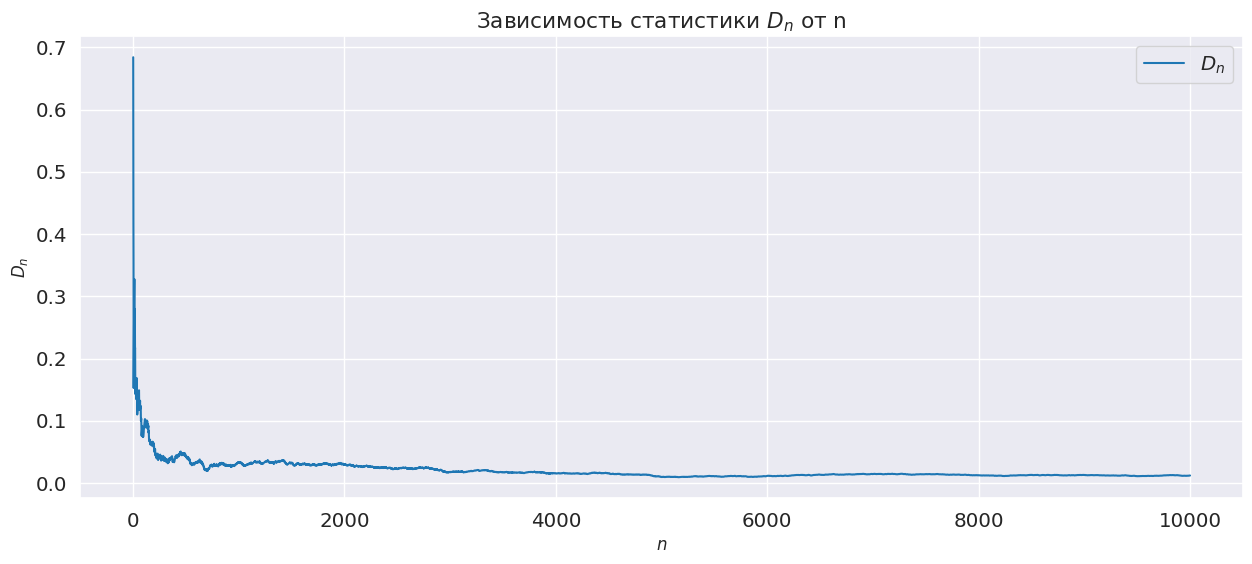

In [10]:
plt.figure(figsize=(15, 6))
plt.plot(range(1, len(X) + 1), D_n_values, label='$D_n$', color='tab:blue')
plt.xlabel(r'$n$', fontsize=12)
plt.ylabel(r'$D_n$', fontsize=12)
plt.title(r'Зависимость статистики $D_n$ от n')
plt.legend()
plt.grid(True)
plt.show()

**Вывод:** 

Значение точное, потому что мы точно знаем $F(x)$

Как видно, действительно $D_n \rightarrow 0$ при $n \rightarrow \infty$, причем довольно быстро, это согласуется с теоремой, что $F_n$ сходится почти наверное к $F$, тогда $D_n$ сходится к 0 почти наверное

Можно использовать статистику $D_n$ для того, чтобы оценить меру того, что выборка имеет функцию распределения равную $F(x)$

---

### Задача 3.

В этой задаче вы исследуете различные непараметрические оценки распределений.
Для этого вам выдается почти готовый код функций `draw_ecdf`, `draw_hist` и `draw_pdf`, которые используются для построения ЭФР, гистограммы и ядерной оценки плотности соответственно. В реализациях этих функция часть кода пропущена, вам нужно его дописать. Код предполагает использование реализации ядерных оценок плотности из `statsmodels`.
При желании вы можете написать аналогичный код, используя реализацию в `seaborn`.

In [11]:
def draw_ecdf(sample, grid, cdf=None):
    """
    По сетке cтроит графики эмпирической функции распределения 
    и истинной (если она задана) для всей выборки и для 1/10 ее части.
    
    Вход:
        sample: выборка
        grid: сетка
        cdf: истинная функция распределения из scipy.stats
    """
    
    plt.figure(figsize=(16, 3))
    # Выбирается размер выборки
    for i, size in enumerate([len(sample) // 10, len(sample)]):
        plt.subplot(1, 2, i + 1)
        
        # Отрисовываются точки выборки на графике    
        plt.scatter(
            sample[:size], 
            np.zeros(size),
            alpha=0.4, label='sample'
        )
        
        # Если передана истинная функция распределения, 
        # отрисовывается ее график
        if cdf is not None:
            plt.plot(
                grid,
                cdf(grid),
                color='green', alpha=0.3, lw=2, label='true cdf'
            )
        
        # Отрисовывается эмпирическую функцию распределения
        ecdf = ECDF(sample[:size])
        plt.plot(
            grid,
            ecdf(grid),
            color='red', label='ecdf'
        )
        
        plt.legend()
        plt.grid(ls=':')
        plt.title('sample size = {}'.format(size))
    plt.show()

И вторая функция

In [12]:
def draw_hist(sample, grid, pdf=None):
    """
    Строит гистограмму и, по сетке, график истинной плотности 
    (если она задана) для всей выборки и для 1/10 ее части.
    
    Вход:
        sample: выборка
        grid: сетка
        pdf: истинная плотность из scipy.stats
    """
    
    plt.figure(figsize=(16, 3))
    # Выбирается размер выборки
    for i, size in enumerate([len(sample) // 10, len(sample)]):
        plt.subplot(1, 2, i + 1)
        
        # Построение гистограммы для выборки
        plt.hist(
            sample[:size], 
            bins=20,
            range=(grid.min(), grid.max()),
            density=True, label='sample hist'
        )
        
        # Если передана истинная плотность, отрисовывается ее график
        if pdf is not None:
            plt.plot(
                grid,
                pdf(grid),
                color='green', alpha=0.3, lw=2, label='true pdf'
            )
        
        plt.legend()
    plt.show()

Последняя

In [13]:
def draw_pdf(sample, grid, pdf=None):
    """
    По сетке cтроит графики ядерной оценки плотности 
    и истинной плотности (если она задана) для всей выборки 
    и для 1/10 ее части.
    
    Вход:
        sample: выборка
        grid: сетка
        pdf: истинная плотность из scipy.stats
    """
    
    plt.figure(figsize=(16, 3))
    # Выбирается размер выборки
    for i, size in enumerate([len(sample) // 10, len(sample)]):
        plt.subplot(1, 2, i + 1)
        
        # Отрисовка точек выборки на графике
        plt.scatter(
            sample[:size], 
            np.zeros(size),
            alpha=0.4, label='sample'
        )
        
        # Если передана истинная плотность, отрисовывается ее график
        if pdf is not None:
            plt.plot(
                grid,
                pdf(grid), 
                color='green', alpha=0.3, lw=2, label='true pdf'
            )

        kde = KDEUnivariate(sample[:size])
        kde.fit()
        # Отрисовывается KDE
        plt.plot(
            grid,
            kde.evaluate(grid),
            color='red', label='kde'
        )
        
        plt.legend()
        plt.grid(ls=':')
    plt.show()

Используя реализованные выше функции, постройте график эмпирической функции распределения (ЭФР), гистограмму и график ядерной оценки плотнотности к выборкам размера 500 для следующих распределений:

*1. Равномерное распределение $U[0,1]$*. Графики функции распределения и плотностей строить на интервале $(-0.2, 1.2)$.

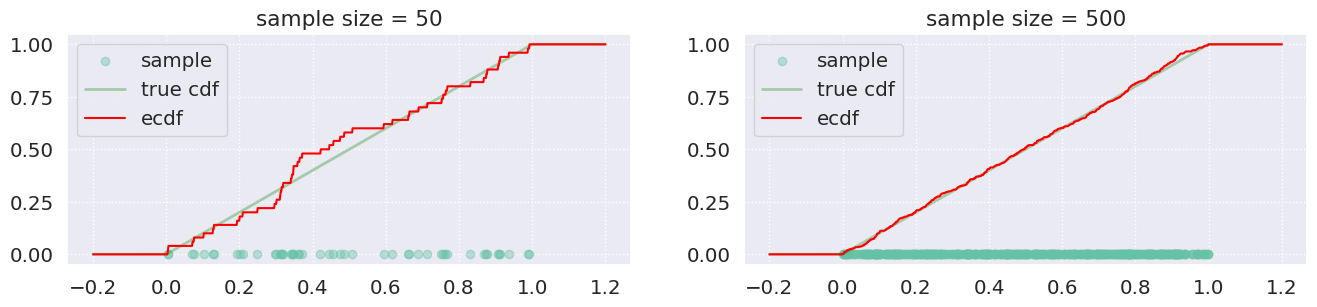

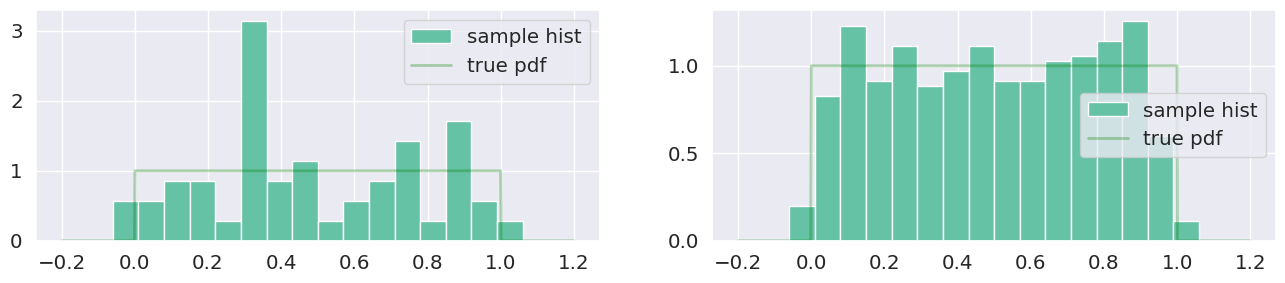

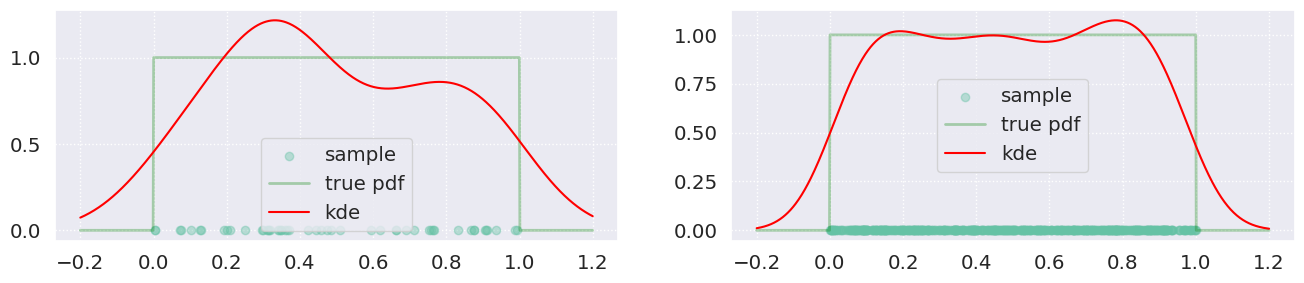

In [14]:
from scipy.stats import uniform, norm, expon
from statsmodels.nonparametric.kde import KDEUnivariate

sample_uniform = np.random.uniform(0, 1, 500)
grid_uniform = np.linspace(-0.2, 1.2, 1000)

draw_ecdf(sample_uniform, grid_uniform, cdf=uniform.cdf)
draw_hist(sample_uniform, grid_uniform, pdf=uniform.pdf)
draw_pdf(sample_uniform, grid_uniform, pdf=uniform.pdf)

*2. Нормальное распределение $\mathcal{N}(0, 1)$.* Графики функции распределения и плотностей строить на интервале $(-3, 3)$.

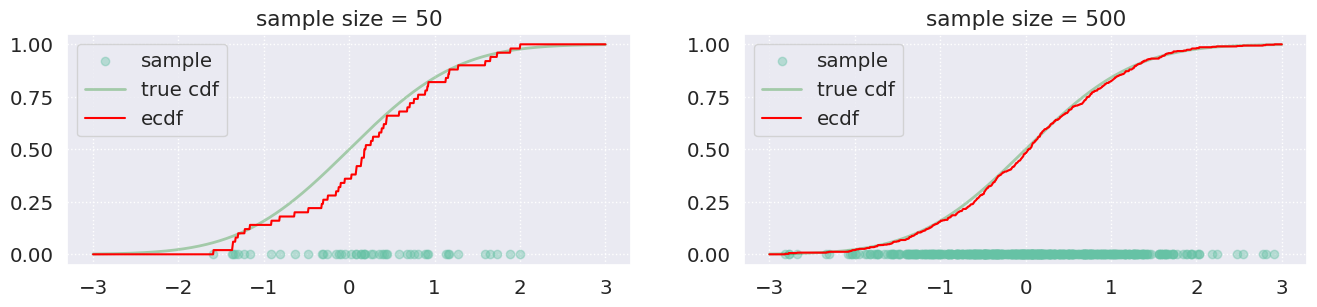

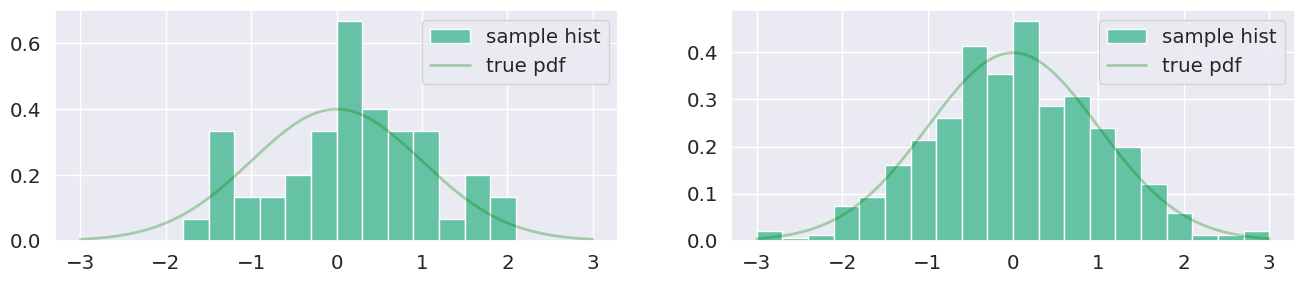

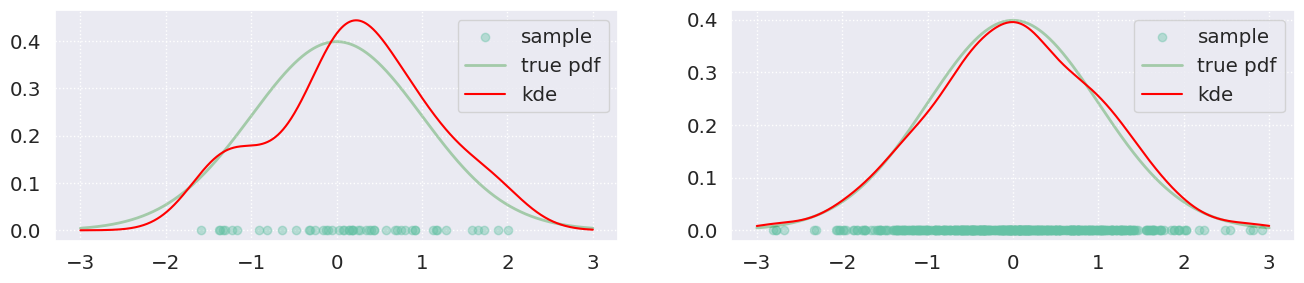

In [15]:
sample_normal = np.random.normal(0, 1, 500)
grid_normal = np.linspace(-3, 3, 1000)

draw_ecdf(sample_normal, grid_normal, cdf=norm.cdf)
draw_hist(sample_normal, grid_normal, pdf=norm.pdf)
draw_pdf(sample_normal, grid_normal, pdf=norm.pdf)

*3. Экспоненциальное распределение $Exp(1)$.* Графики функции распределения и плотностей  строить на интервале $(-0.5, 5)$.

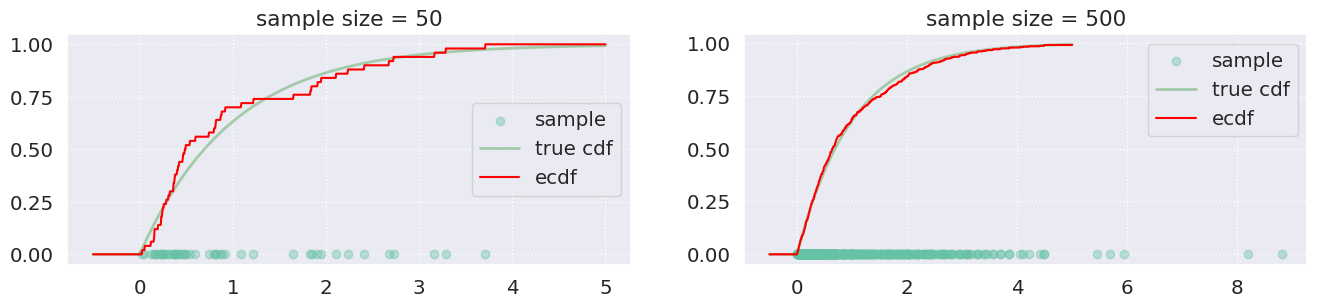

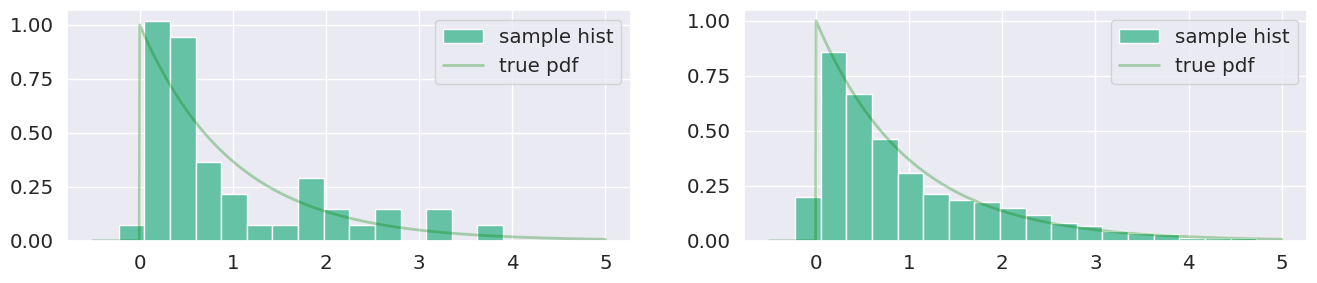

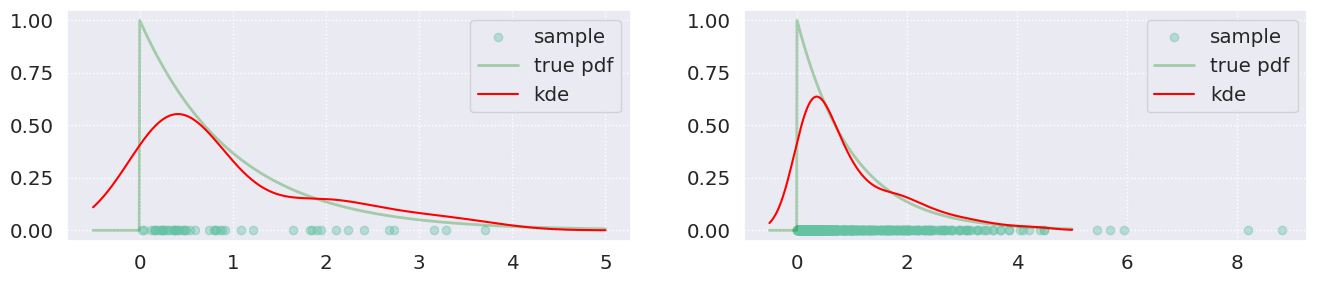

In [16]:
sample_exponential = np.random.exponential(1, 500)
grid_exponential = np.linspace(-0.5, 5, 1000)

draw_ecdf(sample_exponential, grid_exponential, cdf=expon.cdf)
draw_hist(sample_exponential, grid_exponential, pdf=expon.pdf)
draw_pdf(sample_exponential, grid_exponential, pdf=expon.pdf)


Опишите полученные результаты, сравните их между выборками из различных распределений.

**Вывод:**

1) С ростом размера выборки ЭФР приближается к функции распределения X для любого распределения
2) KDE в приближает плотность распределения (если она гладкая), однако, для тех распределений, где она не гладкая (например для экспоненциального распределения есть пик при x = 0; или сама ступенька в равномерном распределении) - приближение отстает. Что логично, гладкой функцией пытаемся приблизить разрывную
3) Итого, в этом смысле ЭФР может оказаться более универсальным, а выбор ядра для ядерной оценки надо проводить более аккуратно; иногда могут понадобиться негладкие ядра

---
### Задача 4.

Исследуйте вид ядерной оценки плотности в зависимости от вида ядра и его ширины.

Для этого сгенерируйте выборку $X_1, ..., X_{200}$ из распределения $U[0, 1]$ и постройте серию графиков для различной ширины гауссовского ядра, а затем другую серию графиков для различных типов ядер при фиксированной ширине. На каждом графике на отрезке $[-0.2, 1.2]$ должны быть изображены истинная плотность (полупрозрачным цветом) и ее ядерная оценка, а так же с нулевой $y$-координатой должны быть нанесены точки выборки. Для экономии места стройте графики в два столбца.

Вам выдется почти готовый код для выполнения задания с некоторыми пропусками. Код предполагает использование реализации ядерных оценок плотности из `statsmodels`. При желании вы можете написать аналогичный код, используя реализацию в `seaborn`. При построении KDE разрешается использовать цикл.

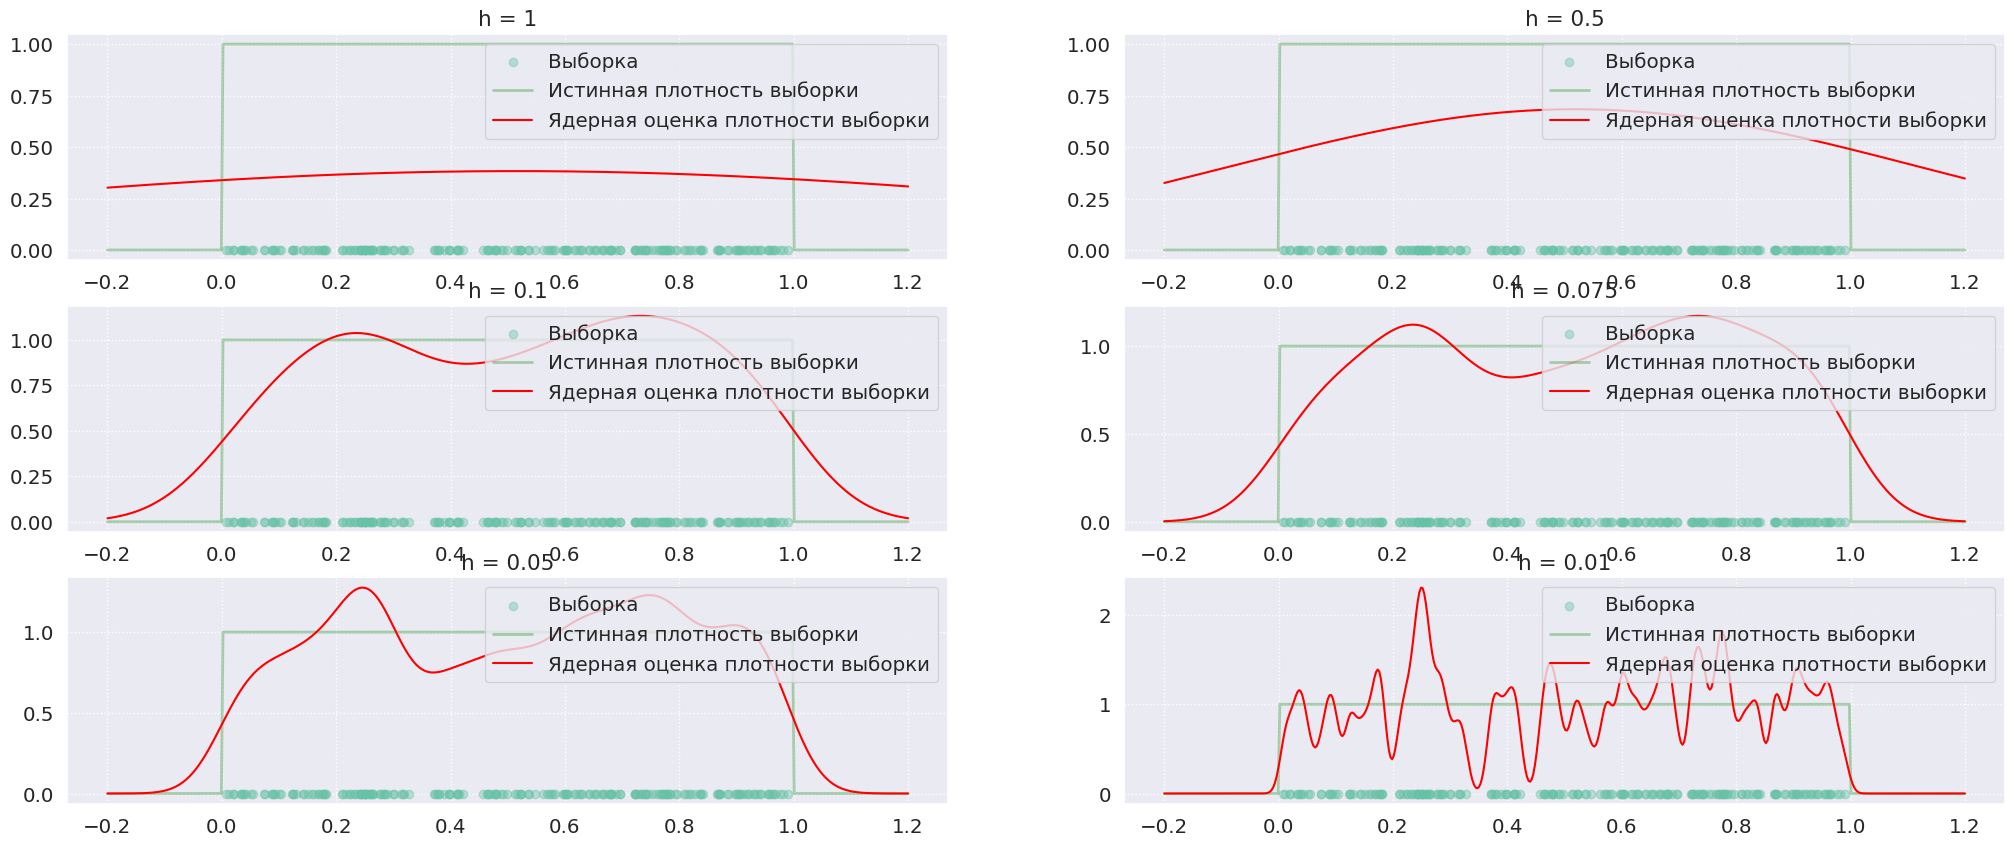

In [17]:
# Размер выборки
size = 200
# Выборка размера size
sample = np.random.uniform(0, 1, size)
# Сетка на отрезке из условия
grid = np.linspace(-0.2, 1.2, 500)

plt.figure(figsize=(25, 10))

# Итераций по ширине ядра
for i, bw in enumerate([1, 0.5, 0.1, 0.075, 0.05, 0.01]):
    plt.subplot(3, 2, i + 1)
    # Построение KDE
    kernel_density = KDEUnivariate(sample)
    kernel_density.fit(bw=bw)
    # Отображение элементов выборки
    plt.scatter(sample, np.zeros(size), alpha=0.4, label='Выборка')
    # Построение истинной плотности выборки
    plt.plot(grid, sps.uniform.pdf(grid, loc=0, scale=1), color='green', 
             alpha=0.3, lw=2, label='Истинная плотность выборки')
    # Отображение KDE плотности
    plt.plot(grid, kernel_density.evaluate(grid), 
             color='red', label='Ядерная оценка плотности выборки')
    plt.legend(loc=1)
    plt.grid(ls=':')
    plt.title('h = {}'.format(bw))
plt.show()

Во втором случае графики постройте аналогичным образом, проведя итерации по типу ядра.

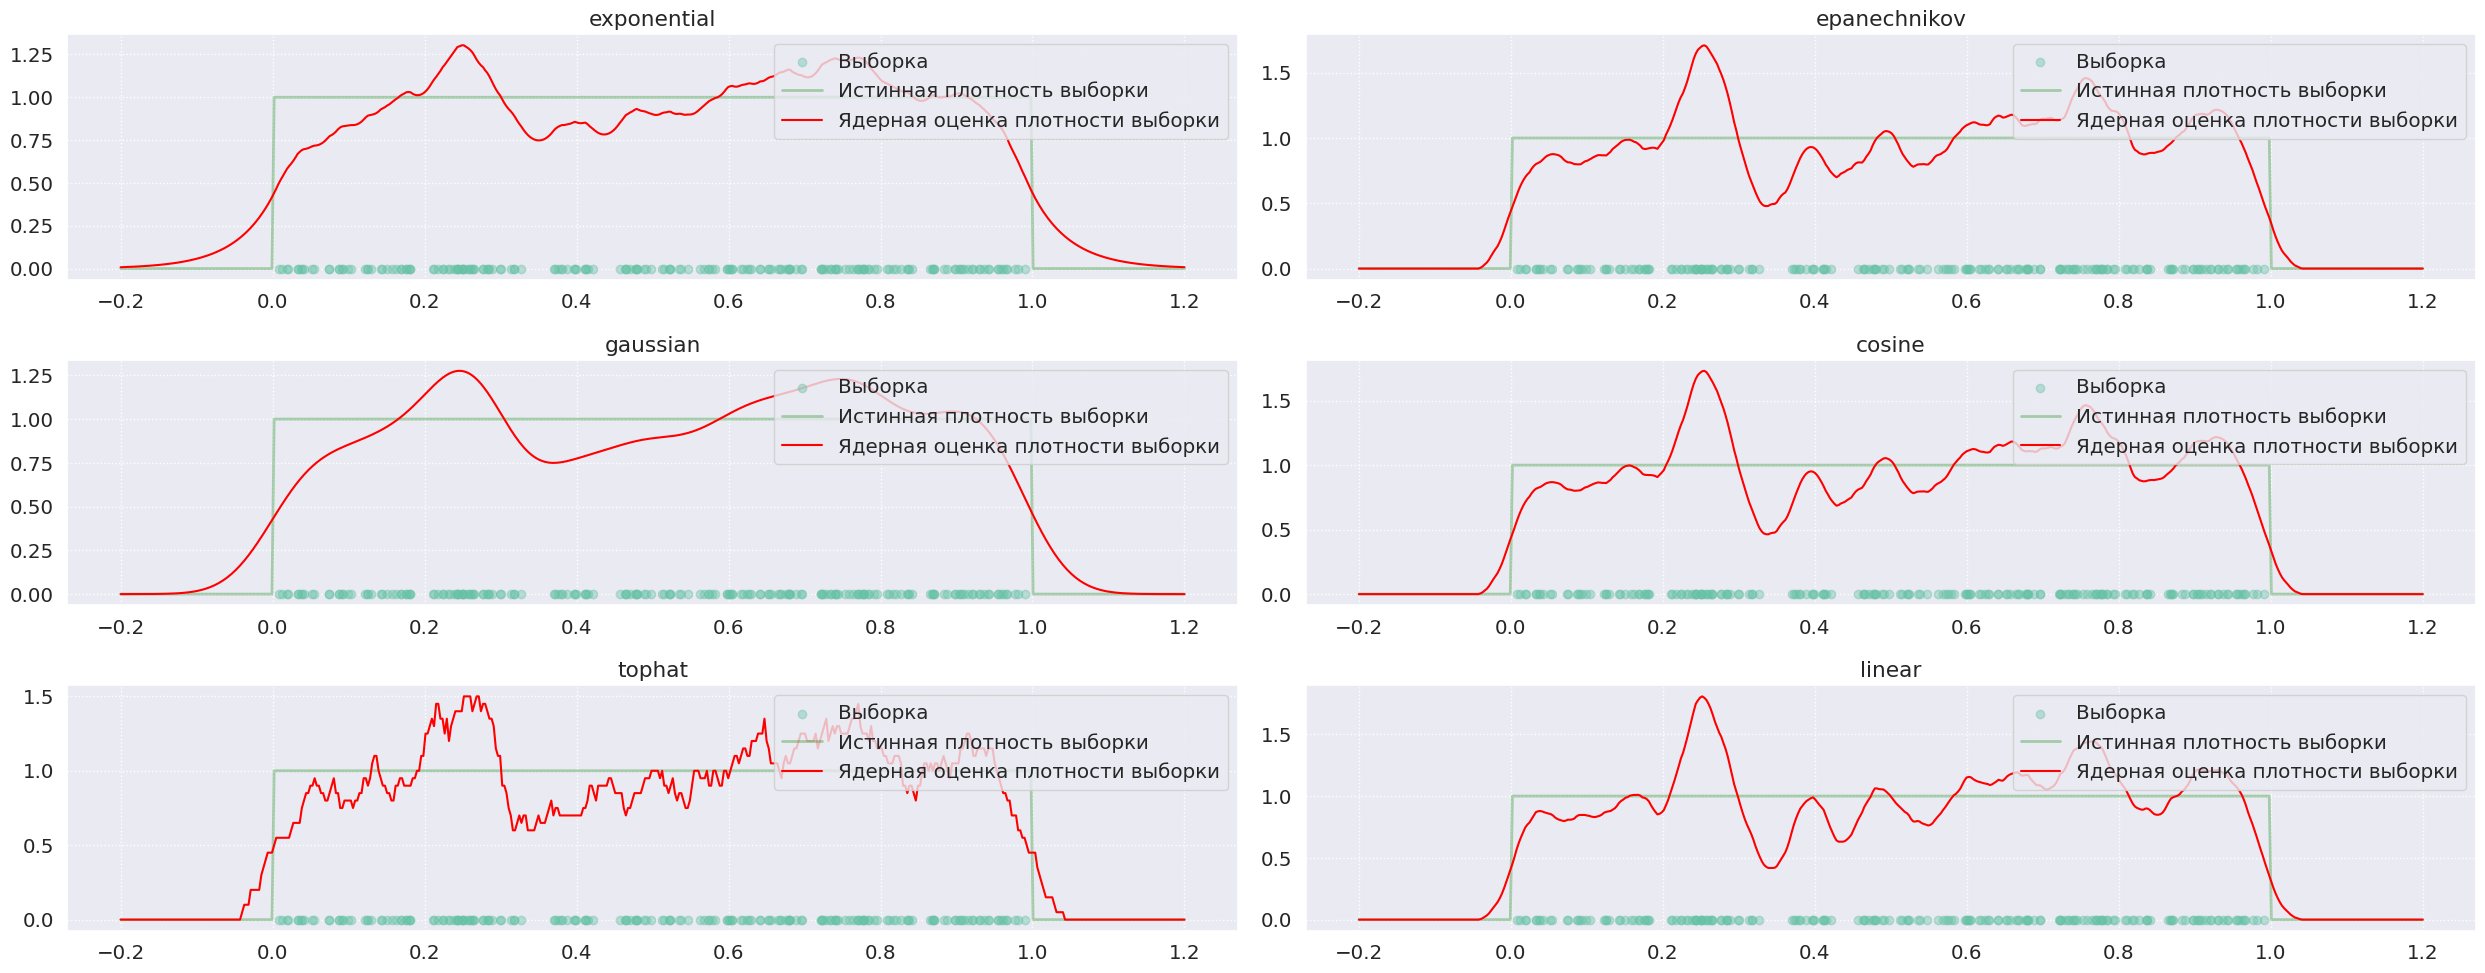

In [18]:
kernel_list = ['exponential', 'epanechnikov',
               'gaussian', 'cosine', 'tophat', 'linear']

plt.figure(figsize=(25, 10))
for i, kernel in enumerate(kernel_list):
    plt.subplot(3, 2, i + 1)
    
    kde = KernelDensity(kernel=kernel, bandwidth=0.05)
    kde.fit(sample[:, np.newaxis])
    density = np.exp(kde.score_samples(grid[:, np.newaxis]))
    plt.scatter(sample, np.zeros(size), alpha=0.4, label='Выборка')
    plt.plot(grid, sps.uniform.pdf(grid, loc=0, scale=1), color='green', 
             alpha=0.3, lw=2, label='Истинная плотность выборки')
    plt.plot(grid, density, 
             color='red', label='Ядерная оценка плотности выборки')
    plt.legend(loc=1)
    plt.grid(ls=':')
    plt.title(kernel)

plt.tight_layout()
plt.show()


**Вывод:**

1) С ростом ширины ядра KDE ближе приближает ступеньку (потому что она быстрее убывает к нулю), однако, если взять слишком узкую ширину - будут слишком резкие пики, и будет расти разброс плотности, хотя его быть не должно 
2) Какие-то ядра более склонны к пикам и ступенчатому вид (tophat), другие же более гладкие (gaussian,  exponential) при одинаковом размере ядра.
3) В реальных задачах следует применять методы валидации, чтобы подобрать лучшее значение ядра и ширины

---
### Задача 5.

Рассмотрим задачу регрессии. Мы уже научились оценивать зависимость $y(x)$, но это только точечная оценка для каждого конкретного $x$. На практике бывает необходимо строить доверительные интервалы, которые в совокупности образуют доверительные ленты. Поскольку мы ничего не знаем про распределение ошибок, будем строить доверительную ленту по методу бутстрепа.

1. Сгенерируем достаточно большое число бутстрепных выборок.

2. Обучим модели и получим значения $\widehat{y}(x)$, для всех значений $x$ по сетке значений.

3. По предсказаным значениям оценим верхнюю и нижнюю границы ленты с помощью методов построения бутстрепных доверительных интервалов.

Напишите функцию, которая реализует данный метод

In [19]:
def bootstrap_confidence_interval(
    X, Y, model, X_grid, bootstrap_count=1000, alpha=0.95, model_args=None
):
    '''
    Построение предсказательной ленты для модели регрессии.
    
    X, Y - выборка;
    model - класс модели;
    X_grid - сетка для доверительной ленты;
    alpha - уровень доверия;
    bootstrap_count - количество бутстрепных выборок
    model_args - параметры модели.
    '''
    
    predictions = []

    for _ in tqdm(np.arange(bootstrap_count)):
        bootstrap_model = model(**model_args)

        X_bootstrap, Y_bootstrap = resample(X, Y)

        bootstrap_model.fit(X_bootstrap, Y_bootstrap)
        
        predictions.append(bootstrap_model.predict(X_grid))
        
    predictions = np.array(predictions)

    lower_bound = np.percentile(predictions, (1 - alpha) / 2 * 100, axis=0)
    upper_bound = np.percentile(predictions, (1 + alpha) / 2 * 100, axis=0)

    return lower_bound, upper_bound


Рассмотрим датасет cps71 из семинара

In [20]:
data = pd.read_csv('cps71.csv', index_col=0)
data.head()
X = data['age'].values.reshape(-1, 1)
y = data['logwage'].values.reshape(-1, 1)

Разделим нашу выборку на обучающую и тестовую

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

Постройте доверительные ленты для моделей линейной регрессии, ядерной регрессии и KNN-регрессии.
Изобразите на графике также предсказания каждой модели и обучающую выборку.

*Примечание: для классов из statmodels сигнатура класса может не совпадать со стандартной, поэтому сделайте для этих классов, класс-обертку, который в себе просто будет вызывать нужные методы.*

Обертка

In [22]:
import statsmodels.api as sm

class StatsModelsWrapper:
    def __init__(self, model_class, args):
        """
        Класс-обертка для моделей из StatsModels
        
        :param model_class: Класс модели из StatsModels
        :param args: аргументы для модели
        """
        self.model_class = model_class
        self.args = args

    def fit(self, X_train, y_train):
        """
        Обучение, которое на самом деле инициализирует модель
        
        :param X_train: признаки
        :param y_train: таргеты
        """
        
        self.model = self.model_class(endog=y_train, exog=X_train,
                                      **self.args)
        self.results = self.model.fit()

    def predict(self, X):
        """
        Предсказания
        
        :param X: признаки
        :return: предсказания
        """
        
        return self.model.fit(X.squeeze())[0]


Сам бустрап

In [23]:
from statsmodels.nonparametric.kernel_regression import KernelReg

models = {
    "Linear": LinearRegression,
    "Kernel": StatsModelsWrapper,
    "KNN": KNeighborsRegressor,
}
model_args = {
    "Linear": {},
    "Kernel": {'model_class': KernelReg,
                          'args': {'var_type': 'c', 'bw': [0.25]}},
    "KNN": {'n_neighbors': 4},
}

X_grid = np.linspace(np.min(X_train),
                     np.max(X_train), 100).reshape(-1, 1)
bootstrap_results = {}
for model_name, model_class in models.items():
    lower_bound, upper_bound = bootstrap_confidence_interval(
        X_train, y_train, model=model_class,
        model_args=model_args[model_name],
        X_grid=X_grid, bootstrap_count=10000
    )
    model = model_class(**model_args[model_name])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_grid)
    bootstrap_results[model_name] = (y_pred, lower_bound, upper_bound)


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

И графики

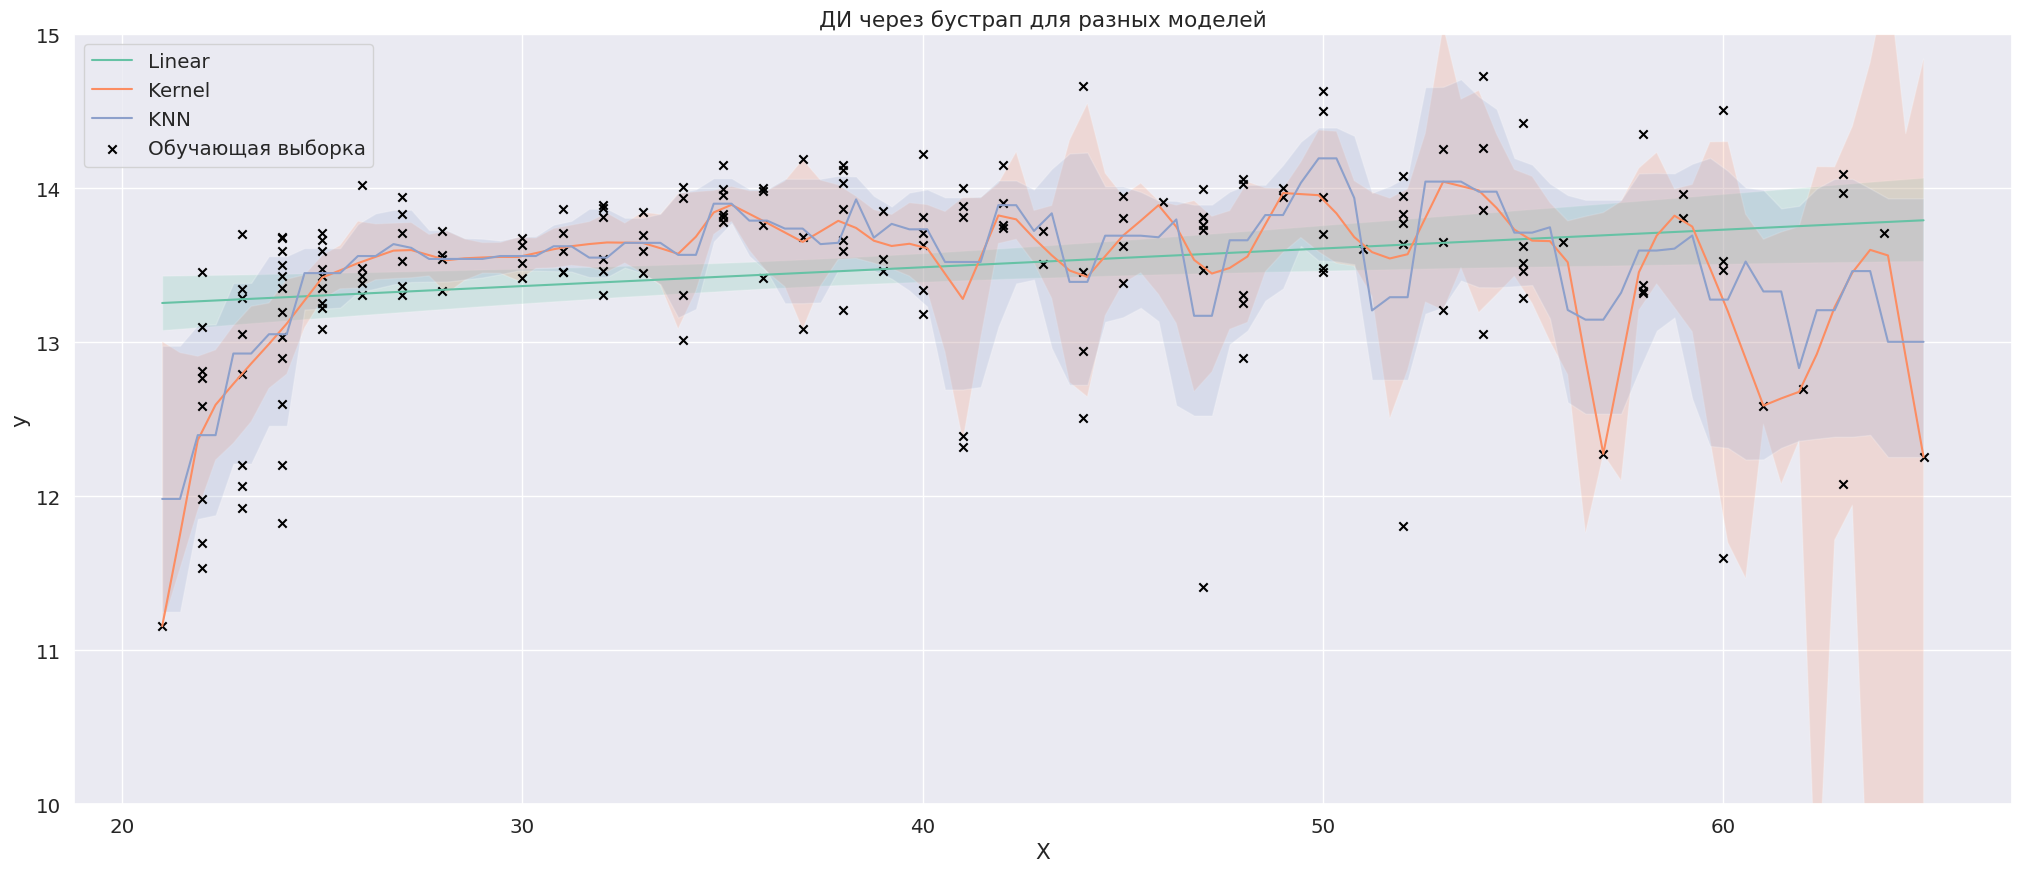

In [24]:
plt.figure(figsize=(25, 10))
for model_name, (y_pred, lower_bound, upper_bound) in bootstrap_results.items():
    plt.plot(X_grid, y_pred, label=f'{model_name}')
    plt.fill_between(X_grid.flatten(),
                     lower_bound.flatten(), upper_bound.flatten(), 
                     alpha=0.2)#, label=f'{model_name} ДИ')

plt.scatter(X_train, y_train, color='black',
            label='Обучающая выборка', marker='x')

plt.xlabel('X')
plt.ylabel('y')
plt.ylim(10, 15)
plt.legend(loc='best')
plt.title('ДИ через бустрап для разных моделей')
plt.show()


Сделайте выводы

**Вывод:**

1) Схожие результаты KNN и Kernel регрессий: обе модели показали близкие прогнозы и доверительные интервалы. Это свидетельствует о том, они хорошо справляются с моделированием сложных нелинейных зависимостей. Однако их интерпретируемость остается ограниченной.
2) Линейная регрессия продемонстрировала узкие доверительные интервалы. Это говорит о низкой вариативности модели и ограниченности её применимости к сложным нелинейным зависимостям. Видно, что модель ошибается: при малых значениях X предсказания отклоняются вниз, а в середине — часть значений выше, а часть ниже линии регрессии. Однако простота и интерпретируемость линейной регрессии остаются её главным преимуществом.
3) Для KNN и Kenel успех напрямую зависит от правильного выбора числа соседей (для KNN) и ширины окна сглаживания (для Kernel). Ошибки в настройке этих параметров могут привести к переобучению или недообучению модели.
4) Бустрап позволяет довольно простым способом оценить ДИ для разных моделей - просто генерируем выборки.